In [1]:
from helper import load_metadata_text
from agents import run_python_da_agent, run_data_scientist_agent, run_orchestrator_agent, run_summarize_agent, run_all_agents
metadata_text = load_metadata_text()

# Input:
## user question: `prompt`

Orchestrator plan:
[{'step_id': 1, 'goal': 'Get Michigan interstate migration counts for low-income AGI classes (under $50k) from 2012 to 2022, aggregated over all ages', 'da_prompt': "From data/processed/soi_migration_long.csv, filter to records where state = 'MI', year between 2012 and 2022 inclusive, age_class = 0, agi_stub in (1, 2, 3), and class in ('total', 'inflow', 'outflow'). For each combination of year, agi_stub, and class, return the sum of n1 and the sum of y2_agi, along with year, agi_stub, class.", 'ds_prompt': None, 'depends_on': []}, {'step_id': 2, 'goal': 'Compute migration rates and income-flow shares for low-income filers in Michigan by AGI class and year', 'da_prompt': None, 'ds_prompt': 'Using the aggregated Michigan dataset from step 1, first reshape so that for each year and agi_stub you have total_n1, inflow_n1, outflow_n1, total_y2_agi, inflow_y2_agi, and outflow_y2_agi. Then compute for each year and agi_stub: inflow_rate = inflow_n1 / total_n1, outflow_rate 

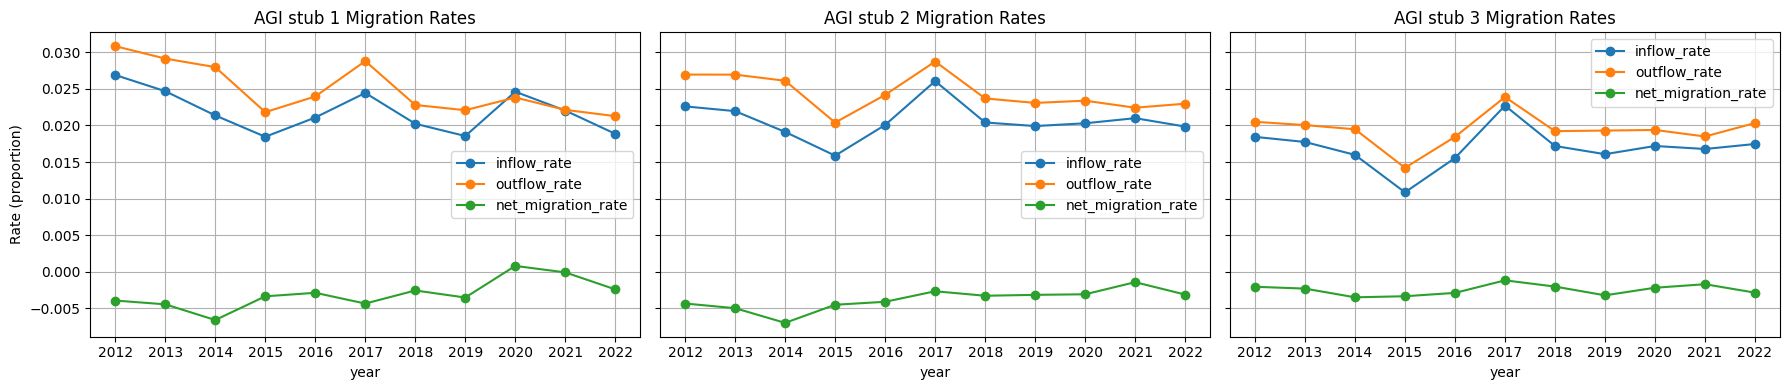

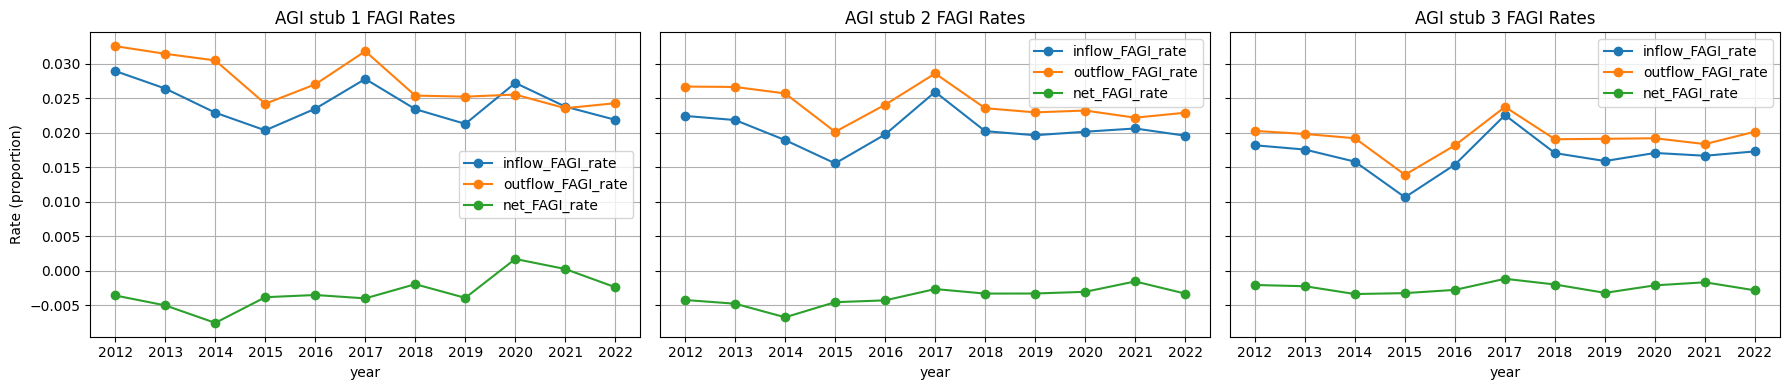


--- Step 2 ---
Message  before LLM call: {'role': 'tool', 'tool_call_id': 'call_fU8Rc2ITnq5cDVhYMjnnCoyX', 'content': '{"success": false, "stdout": "", "stderr": "", "execution_time_seconds": 0.5049, "error": "invalid syntax (<string>, line 54)", "error_type": "SyntaxError", "traceback": "Traceback (most recent call last):\\n  File \\"c:\\\\Users\\\\gongz\\\\migration-agent\\\\tools.py\\", line 67, in execute_python_code\\n    exec(code, env)\\n  File \\"<string>\\", line 54\\n    \'sum_y2_agi\': {\'description\': \'Sum of y2_agi (Year-2 AGI) aggregated as specified\', \'units\': \'thousand dollars (nominal)\'; },\\n                                                                                                                             ^\\nSyntaxError: invalid syntax\\n"}'}

[LLM RESPONSE]
Tool calls:
- execute_python_code({"code":"import pandas as pd\n\n# Load processed SOI migration data\ndf = pd.read_csv(\"data/processed/soi_migration_long.csv\")\n\n# Build mask for Michigan: pr

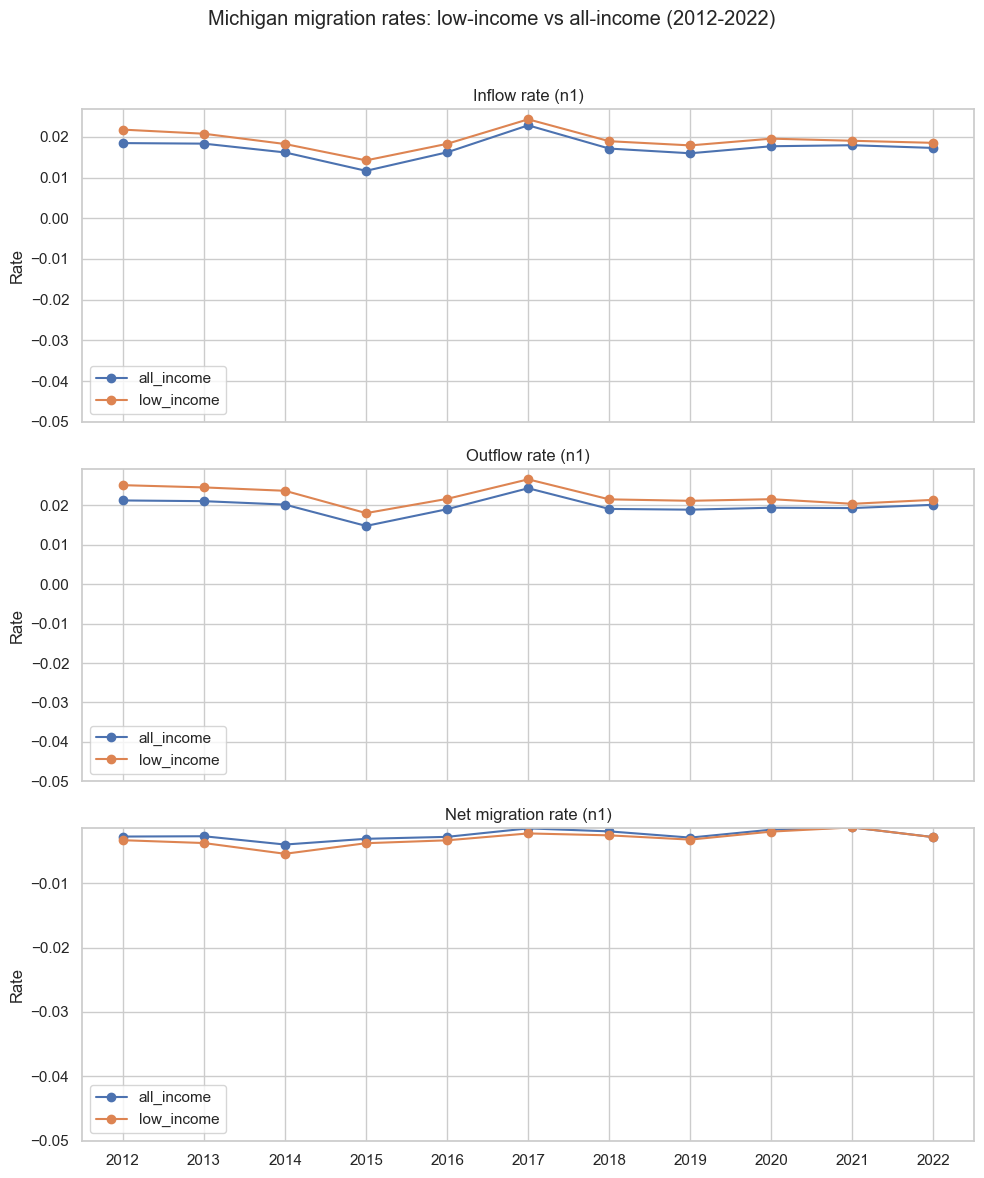


Tool call: execute_python_code with args {"code":"# Summarize means and identify years with max/min for key metrics\nsummary = {}\nfor grp in result_df['group'].unique():\n    g = result_df[result_df['group']==grp]\n    summary[grp] = {\n        'mean_inflow_rate': g['inflow_rate'].mean(),\n        'mean_outflow_rate': g['outflow_rate'].mean(),\n        'mean_net_migration_rate': g['net_migration_rate'].mean(),\n        'mean_inflow_FAGI_rate': g['inflow_FAGI_rate'].mean(),\n        'mean_outflow_FAGI_rate': g['outflow_FAGI_rate'].mean(),\n        'mean_net_FAGI_rate': g['net_FAGI_rate'].mean(),\n        'max_inflow_rate_year': int(g.loc[g['inflow_rate'].idxmax(),'year']),\n        'max_inflow_rate_value': float(g['inflow_rate'].max()),\n        'min_inflow_rate_year': int(g.loc[g['inflow_rate'].idxmin(),'year']),\n        'min_inflow_rate_value': float(g['inflow_rate'].min()),\n        'max_outflow_rate_year': int(g.loc[g['outflow_rate'].idxmax(),'year']),\n        'max_outflow_rate_

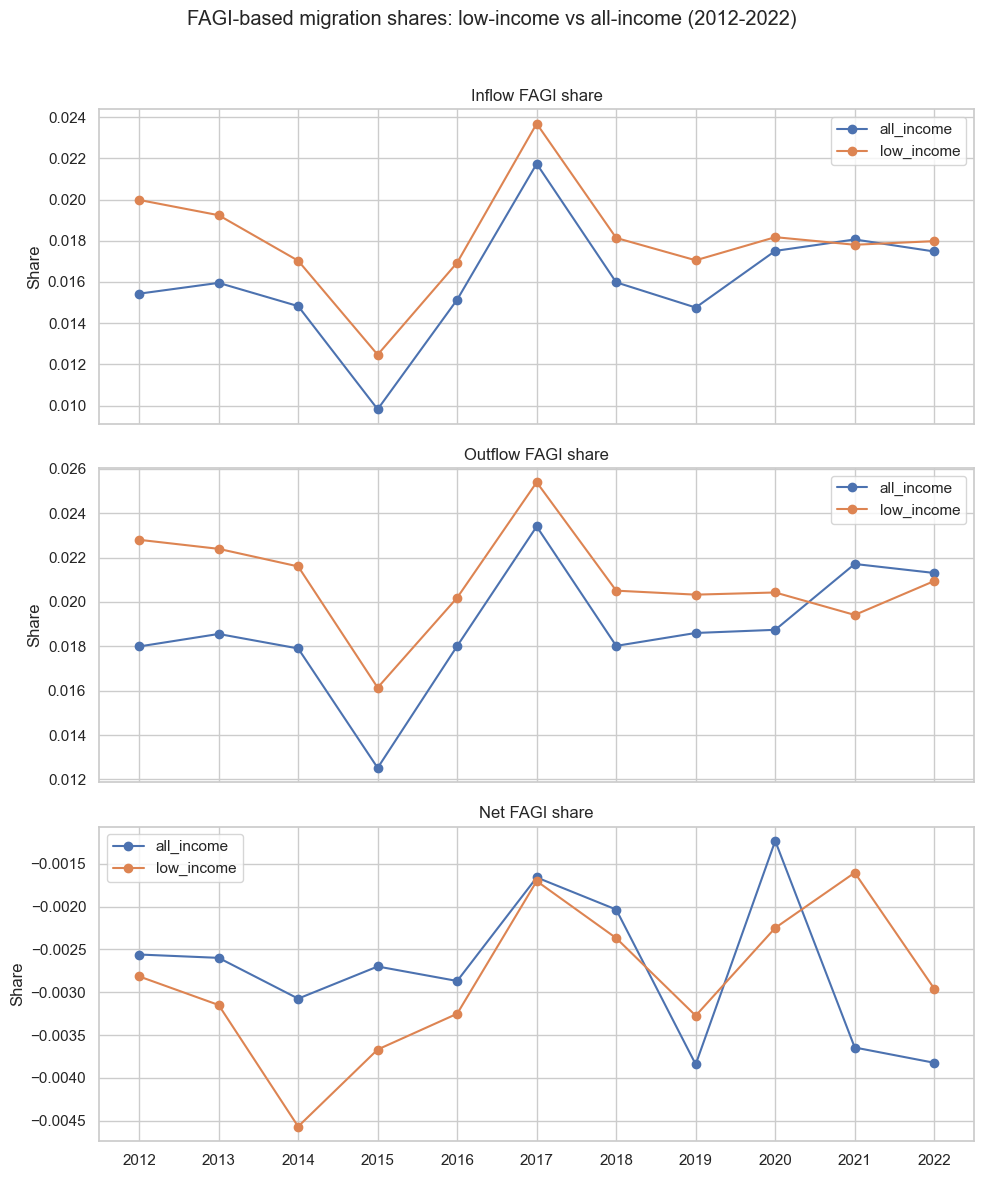


--- Data Scientist Agent: Step 3 ---
[DS] Output of DS step 4:
I computed the requested per-year rates from the two aggregated tables in df_3 and produced two time-series figures (2012–2022):

- Figure A: inflow_rate, outflow_rate, net_migration_rate (n1-based) — low_income vs all_income
- Figure B: inflow_FAGI_rate, outflow_FAGI_rate, net_FAGI_rate (FAGI-based shares) — low_income vs all_income

Key numeric summaries (2012–2022 averages and extremes)

- Averages (2012–2022)
  - All-income (agi_stub = 0)
    - mean inflow_rate = 0.01722 (1.722%)
    - mean outflow_rate = 0.01976 (1.976%)
    - mean net_migration_rate = -0.00253 (-0.253%)
    - mean inflow_FAGI_rate = 0.01607 (1.607%)
    - mean outflow_FAGI_rate = 0.01880 (1.880%)
    - mean net_FAGI_rate = -0.00273 (-0.273%)
  - Low-income (combined agi_stub 1–3)
    - mean inflow_rate = 0.01921 (1.921%)
    - mean outflow_rate = 0.02232 (2.232%)
    - mean net_migration_rate = -0.00311 (-0.311%)
    - mean inflow_FAGI_rate = 0.01805

In [2]:
prompt = "Analyze the interstate migration pattern of Michigan, from 2012 to 2022."
focus = "Focus on different behavior between low income classes (annual gross income less than $50,000)."
results = run_all_agents(original_prompt=prompt, focus= focus, metadata_text= metadata_text, verbose = True)

In [4]:
results.keys()

dict_keys(['summary', 'stat_df', 'stat_metadata', 'report', 'figures'])

In [5]:
print(results['summary'])

Key Findings:
- Low-income Michiganders (under $50,000 AGI) are consistently more mobile than the overall population, with both higher inflow and higher outflow rates every year from 2012–2022.  
- On average, low-income inflow rates are about 0.20 percentage points higher than for all incomes (1.921% vs 1.722%), and outflow rates about 0.26 points higher (2.232% vs 1.976%) (from ds_step_4).  
- This higher mobility translates into a slightly larger net loss of low‑income residents: average net migration is −0.311% for low‑income vs −0.253% for the full population (2012–2022).  
- Within the low‑income range, the very lowest incomes ($1–10k and $10–25k) saw declining inflow and outflow rates over 2012–2022, with net losses becoming somewhat smaller, while the $25–50k group’s net loss became slightly worse (from ds_step_2).  
- Income flows mirror people flows: low‑income filers account for somewhat higher shares of inflow and outflow AGI than the overall population and also show slight

In [ ]:
results['report']

## Customized Input: Focus

In [ ]:
prompt = '''
Compute the 5-year median net-migration rate, from 2018 to 2022, of Minnesota for all age and agi classes. 
Compute the 5-year median (during the same time) of the net-migration rates for the Midwest Region for the same classes. 
Compare them by using Minnesota rates subtracted by the midwest rates. Use a heatmap to visualize the difference (Both these rates are in percentage).
'''
focus = "Make the report more tech oriented. The main audience are analysts"

results = run_all_agents(original_prompt=prompt , focus= focus, metadata_text= metadata_text, verbose = False)

# Testing Use Only
The following codes are for testing purposes
## Orchestrator agent

In [ ]:
from agents import build_focus

prompt = "Compare the migration activities between Minnesota and Wisconsin, from 2015 to 2022."
focus = "Pay extra attention to the difference between different age and agi classes."

user_prompt = build_focus(original_question=prompt, focus = focus)
plan = run_orchestrator_agent(user_prompt=prompt, metadata_text=metadata_text)


In [ ]:
plan['plan']

In [ ]:
verbose = True

if verbose:
    print(f"Orchestrator plan:\n{plan['plan']}\n")

if plan['requires_clarification']:
    results = {
        "type": "clarification",
        "question": plan['clarification_question']
    }
else:
    shared_env = {}
    shared_meta = {}
    ds_report = {}
    for step in plan['plan']:
        step_id = step['step_id']
        goal = step['goal']
        da_prompt = step['da_prompt']
        ds_prompt = step['ds_prompt']
        depends_on = step['depends_on']

        if verbose:
            print(f"\n---Executing Step {step_id}: {goal} ---\n")

        if da_prompt is not None:
            if verbose:
                print(f"[DA] Running DA step {step_id} with prompt:\n{da_prompt}\n")

            output = run_python_da_agent(
                user_prompt=da_prompt,
                metadata_text="",
                verbose=False,
            )

        if ds_prompt is not None:
            if verbose:
                print(f"[DS] Running DS step {step_id} with prompt:\n{ds_prompt}\n")
                print(f"[DS] Depends on: {depends_on}")

            # Assemble DS environment containing all needed DA results
            ds_env = {}
            ds_meta = {}
            for dep in depends_on:
                try:
                    ds_env[f"df_{dep}"] = shared_env[f"df_{dep}"]
                    ds_meta[f"df_{dep}"] = shared_meta[f"df_{dep}"]
                except: 
                    pass
            output = run_data_scientist_agent(
                user_prompt=ds_prompt,
                env=ds_env,
                env_meta=ds_meta,
                max_steps = 5,
                verbose=False,
            )

            if verbose:
                print(f"[DS] Output of DS step {step_id}:\n{output.get('answer')}\n")

            ds_report[f"ds_step_{step_id}"] = output.get("answer")
        
        try:
            shared_env[f"df_{step_id}"] = output.get("dataframe")
            shared_meta[f"df_{step_id}"] = output.get("metadata")
        except:
            pass


In [ ]:
run_summarize_agent(ds_report=ds_report, user_prompt = user_prompt, metadata_text= metadata_text)

In [ ]:
prompt = "Compute the out migration rate of MN whose gross income is over $100,000 from 2015 to 2022"
answer = run_python_da_agent(prompt, metadata_text, max_steps=5)
if answer["dataframe"] is not None:
    df1 = answer['dataframe']
    df1_meta = answer['metadata']


In [ ]:
prompt = "Compute the out-migration rate of high-income households (gross income over $100,000) in the Midwest region from 2015 to 2022."
answer = run_python_da_agent(prompt, metadata_text, max_steps=5)
if answer["dataframe"] is not None:
    df2 = answer["dataframe"]
    df2_meta = answer["metadata"]

In [ ]:
prompt = "What is the annual national average out-migration rates for high-income households (gross income over $100,000), from 2015 to 2022?"
answer = run_python_da_agent(prompt, metadata_text, max_steps=5)
if answer["dataframe"] is not None:
    df3 = answer["dataframe"]
    df3_meta = answer["metadata"]

In [ ]:
env = {"df1": df1, "df2": df2, "df3": df3}
env_meta = {"df1": df1_meta, "df2": df2_meta, "df3": df3_meta}

In [ ]:
prompt ='''
Analyze the trend of out-migration rate with of higher income households (gross income over $100,000) in Minnesota, 
and compare it with the corresponding rates in Midwest and the national average. The data is provided in `env`. 
Provide insights on how Minnesota's out-migration rate for high-income households differs from regional and national trends between 2015 and 2022. 
'''
answer = run_data_scientist_agent(user_prompt=prompt, env = env, env_meta=env_meta, metadata_text=metadata_text, max_steps=5, verbose=False)
print(answer['answer'])

In [ ]:
prompt = "Compute the average net migration rates of the Midwest region, from 2018 to 2022, for each age calss and agi class combination."
answer = run_python_da_agent(prompt, metadata_text, max_steps=5)
if answer["dataframe"] is not None:
    data_midwest = answer

prompt = "Compute the average net migration rates of Minnesota, from 2018 to 2022, for each age calss and agi class combination."
answer = run_python_da_agent(prompt, metadata_text, max_steps=5)
if answer["dataframe"] is not None:
    data_mn = answer

In [ ]:
env = {"df_midwest": data_midwest["dataframe"], "df_mn": data_mn["dataframe"]}
env_meta = {"df_midwest": data_midwest["metadata"], "df_mn": data_mn["metadata"]}

In [ ]:
prompt ='''
Compare the net migration rates (use percentage as its unit) between Minnesota and the Midwest region from 2018 to 2022, segmented by age class and AGI class.
Use a heatmap to visualize the differences between Minnesota and the Midwest region across these segments.
'''
answer = run_data_scientist_agent(user_prompt=prompt, env = env, env_meta=env_meta, metadata_text=metadata_text, max_steps=5, verbose=False)
print(answer['answer'])